## Purpose of analysis:

*Inspired by https://www.kaggle.com/code/artemburenok/stock-analysis-monte-carlo-build-portfolio*

* Build moving average of varios stocks 
* Determine correlations between stock returns 
* Create an optimal portfolio
* Try to predict the future behavior of the stocks 

*Using data https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset*

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data
from datetime import datetime

ArgumentError: ArgumentError: Package numpy not found in current path.
- Run `import Pkg; Pkg.add("numpy")` to install the numpy package.

In [3]:
# Setting the begining and ending
today = datetime.now()
year_ago = datetime(today.year-1, today.month, today.day)

In [22]:
# Four company for data extraction
stocks=True
company_list = ['MMM', 'AMZN', 'CAT', 'AI', 'AIR', 'AM', 'TWTR', 'TSLA', 'MSFT', 'TTE']

In [23]:
#globals()- taking the string and makes it a global variable
companies = {}
for company in company_list:
    if stocks: dir_name='../data/stocks/'
    else: dir_name='../data/etfs/'
    fn = dir_name + company + '.csv'
    companies[company] = pd.read_csv(fn, index_col='Date', parse_dates=True)

In [25]:
len(list(companies.keys()))

9

In [9]:
TWTR.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-11-07,45.099998,50.090000,44.000000,44.900002,44.900002,117701600
2013-11-08,45.930000,46.939999,40.689999,41.650002,41.650002,27925300
2013-11-11,40.500000,43.000000,39.400002,42.900002,42.900002,16113900
2013-11-12,43.660000,43.779999,41.830002,41.900002,41.900002,6316700
2013-11-13,41.029999,42.869999,40.759998,42.599998,42.599998,8688300


In [10]:
TSLA.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [ ]:
MSFT.head(5)

In [ ]:
AMZN.head(5)

In [15]:
TWTR.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1610 entries, 2013-11-07 to 2020-04-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1610 non-null   float64
 1   High       1610 non-null   float64
 2   Low        1610 non-null   float64
 3   Close      1610 non-null   float64
 4   Adj Close  1610 non-null   float64
 5   Volume     1610 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 88.0 KB


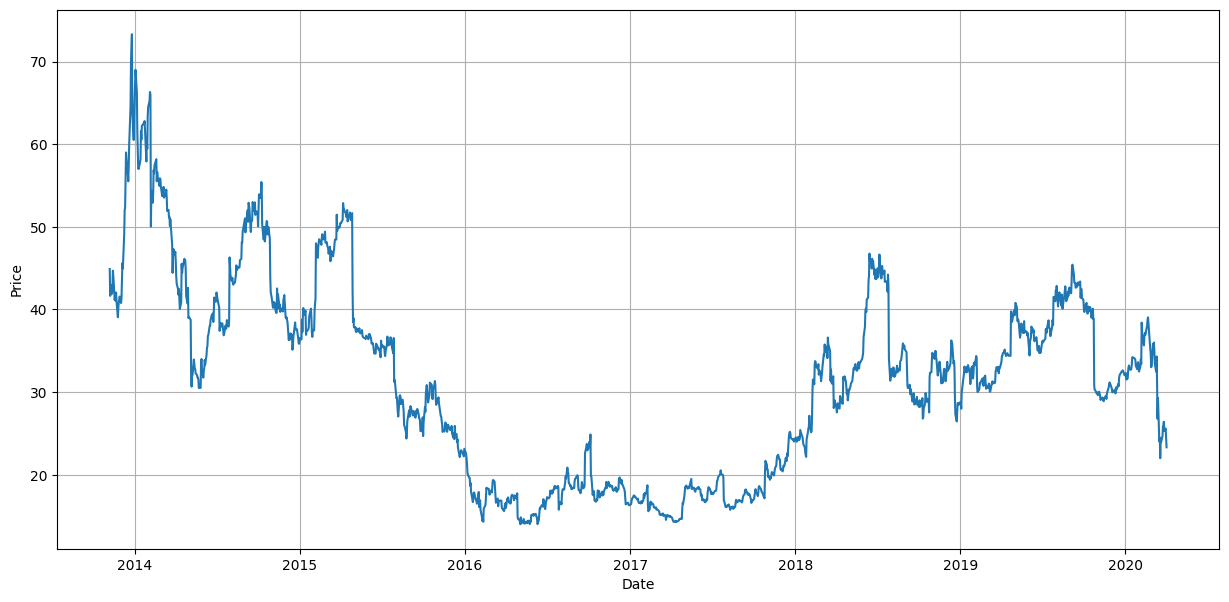

In [26]:
plt.figure(figsize=(15, 7))
plt.plot(TWTR['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()

<AxesSubplot: xlabel='Date'>

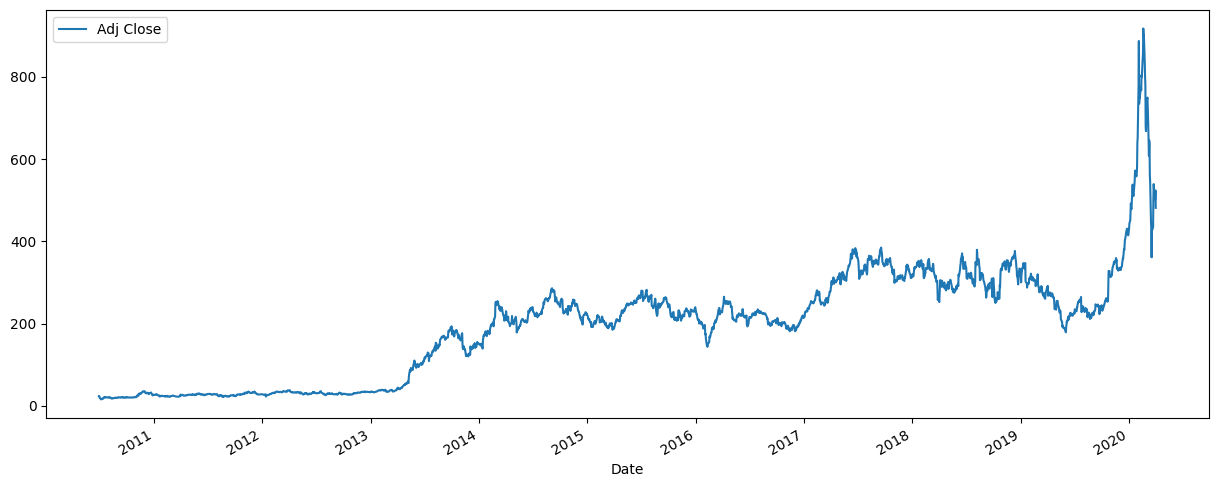

In [17]:
TSLA['Adj Close'].plot(legend=True, figsize=(15, 6))

## Moving average

Moving average - function whose value at each point is equal to some average value of the original function for the previous period. 

Formula for calculations:

SUM = sum of prices for past x days; MA = SUM / x 

In [ ]:
MA_days = [10, 20, 30]

for ma in MA_days:
    ma_str = "MA: {}".format(ma)
    TWTR[ma_str] = TWTR['Adj Close'].rolling(ma).mean()
    TSLA[ma_str] = TSLA['Adj Close'].rolling(ma).mean()
    MSFT[ma_str] = MSFT['Adj Close'].rolling(ma).mean()
    AMZN[ma_str] = AMZN['Adj Close'].rolling(ma).mean()

In [ ]:
TWTR.head()

In [ ]:
def plot_graphic(company, company_string):
    plt.figure(figsize=(15, 6))
    plt.plot(company['Adj Close'])
    plt.plot(company['MA: 10'])
    plt.plot(company['MA: 20'])
    plt.plot(company['MA: 30'])
    
    plt.title(company_string)
    plt.xlabel('Date')
    plt.ylabel('Price')

    plt.legend(('Adj Close','MA: 10', 'MA: 20', 'MA:30'))
    plt.grid()
    plt.show()

In [ ]:
data_list = [TWTR, TSLA, MSFT, AMZN]

for i in range(len(data_list)):   
    plot_graphic(data_list[i], company_list[i])

If a long-term investment is being considered, then it is better to consider a smoother curve, since it is more resistant to sharp price jumps.

In [ ]:
# Calculate returns and draw distribution

for i in range(len(data_list)):
    data_list[i]['Daily Returns'] = data_list[i]['Adj Close'].pct_change()
    sns.displot(data_list[i]['Daily Returns'].dropna(), bins=50, color='blue', kde=True)
    plt.title(company_list[i])
    plt.show()

## Correlation between stock returns

In [ ]:
# Create dataframe with stock returns
stock_returns = pd.DataFrame(data=np.array([data['Daily Returns'] for data in data_list]).T, columns=company_list)
stock_returns.head()

In [ ]:
sns.pairplot(stock_returns.dropna())

In [ ]:
# Build correlation matrix
corr = stock_returns.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 10))
sns.heatmap(corr, mask=mask,  square=True, linewidths=.5, annot=True)
plt.show()

In [ ]:
def draw_jointplot(data):
    grid = sns.PairGrid(data.dropna())
    grid.map_diag(sns.histplot, bins=40, kde=True)
    grid.map_lower(sns.regplot)
    grid.map_upper(sns.kdeplot)

In [ ]:
draw_jointplot(stock_returns)

From graphics we have see positive correlation, but it is within [0.24, 0.55]. Amazon and Microsoft have the most correlated daily profits. Tesla and Twitter have the lowest correlation. 

## Portfolio strategy

Let's try to make an optimal portfolio of four stocks. Following the classical theory, it is necessary to minimize risk and maximize profitability. We will generate random ratios of stocks, calculate the risk and profitability of each portfolio according to the given formulas.

The expected return of the portfolio is the total expected return of the securities included in it, weighted taking into account their share in the portfolio. 

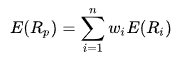

The basic formula for calculating risk is based on the relationship between the shares in the portfolio and the covariance associated with each of the securities in the portfolio.

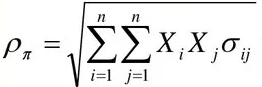

In [ ]:
mean_income = stock_returns.mean() # Mean income for each stock
cov_returns = stock_returns.cov() # Covariation 
count = len(stock_returns.columns)
print(mean_income, cov_returns, sep='\n')

In [ ]:
# Function, that generate random shares
def randomPortfolio():
    share = np.exp(np.random.randn(count))
    share = share / share.sum()
    return share

In [ ]:
def IncomePortfolio(Rand):
    return np.matmul(mean_income.values, Rand)


def RiskPortfolio(Rand):
    return np.sqrt(np.matmul(np.matmul(Rand, cov_returns.values), Rand))

In [ ]:
combinations = 4000
risk = np.zeros(combinations)
income = np.zeros(combinations)
portfolio = np.zeros((combinations, count))

# Function, which create new combinations of shares
for i in range(combinations):
    rand = randomPortfolio()

    portfolio[i, :] = rand
    risk[i] = RiskPortfolio(rand)
    income[i] = IncomePortfolio(rand)

The Sharpe ratio is the ratio of return to risk.

In [ ]:
plt.figure(figsize=(15, 8))

plt.scatter(risk * 100, income * 100, c="b", marker=".")
plt.xlabel("Risk")
plt.ylabel("Income")
plt.title("Portfolios")
MaxSharpRatio = np.argmax(income / risk)
plt.scatter([risk[MaxSharpRatio] * 100], [income[MaxSharpRatio] * 100], c="r", marker="o", label="Max Sharp ratio")

plt.legend()
plt.show()

In [ ]:
best_port = portfolio[MaxSharpRatio]
for i in range(len(company_list)):
    print("{} : {}".format(company_list[i], best_port[i]))

## Try to predict price behavior with method Monte Carlo

In [ ]:
days = 365
dt = 1 / days
stock_returns.dropna(inplace=True)

mu = stock_returns.mean()
sigma = stock_returns.std()

In [ ]:
def monte_carlo(start_price, days, mu, sigma):
    price = np.zeros(days)
    price[0] = start_price
    
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    for x in range(1, days):
        shock[x] = np.random.normal(loc=mu * dt, scale=sigma*np.sqrt(dt))
        drift[x] = mu * dt
        
        price[x] = price[x-1] + (price[x-1] * (drift[x] + shock[x]))
        
    return price

### Twitter

In [ ]:
TWTR.tail()

In [ ]:
start_price = 35.65
sim = np.zeros(1000)

plt.figure(figsize=(15, 8))
for i in range(1000):
    result = monte_carlo(start_price, days, mu['TWTR'], sigma['TWTR'])
    sim[i] = result[days - 1]
    plt.plot(result)
    
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Monte Carlo analysis for Twitter')


In [ ]:
plt.figure(figsize=(10, 7))
plt.hist(sim, bins=100)
plt.figtext(0.6, 0.7, "Mean: {} \nStd: {} \nStart Price: {}".format(sim.mean(), sim.std(), start_price))
plt.show()

Start price was 35.65, mean final price is 35.59. As we can see, final price is lower then start. Although the variance is small